In [2]:
import os
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import scipy
import copy
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import torchvision
import torch.utils.data
from matplotlib import pyplot as plt
from tqdm import tqdm
from drive.MyDrive.Colab_Notebooks.Diffuse_553.ddpm_553.utils import *
from drive.MyDrive.Colab_Notebooks.Diffuse_553.ddpm_553.UNet import UNet, UNet_conditional, EMA
import logging
from torch.utils.tensorboard import SummaryWriter
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if os.path.exists('./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553'):
  print("1")

1


In [ ]:
!pip install pytorch_fid
from pytorch_fid import fid_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0]
args.run_name = "DDPM_conditional"
args.epochs = 200
args.batch_size = 128
args.image_size = 32
args.num_classes = 10
args.dataset_path = "./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets"
#args.subset_path = "./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images"
args.device = "cuda"
args.lr = 3e-4
args.loss_type = 'mse'  # 'mse' or 'l1'

In [ ]:
# get cifar_10 data
def get_data_cifar10(args):
    transforms = torchvision.transforms.Compose([
        #torchvision.transforms.Resize(40),  # args.image_size + 1/4 *args.image_size
        #torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    #dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataset_un = torchvision.datasets.CIFAR10(root= args.dataset_path,train=False, transform=transforms, download=False)
    dataloader = DataLoader(dataset_un, batch_size=args.batch_size, shuffle=True)
    return dataloader, dataset_un

In [ ]:
## -------------run only for the first time !!---------------

# Create the directory for CIFAR10 subset images
os.makedirs('./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images', exist_ok=True)

# Create the directory for CIFAR10 generated images
os.makedirs('./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_generate_images', exist_ok=True)

# generate a subset of cifar_10
dataloader, dataset_un = get_data_cifar10(args)
n = 10000  # create subset 
cifar10_subset, _ = torch.utils.data.random_split(dataset_un, [n,len(dataset_un)-n])
cifar10_subset_dataloader_un = DataLoader(cifar10_subset, batch_size=args.batch_size, shuffle=True)

#save images to path
for i, (image, _) in enumerate(cifar10_subset):
    save_image(image,f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images/image_{i}.png')


In [ ]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self, use_cosine=False, s=0.008):  
        if use_cosine == True:
            def f(t, noise_steps):
                return (np.cos((t / noise_steps + s) / (1 + s) * np.pi / 2)) ** 2
            alphas = []
            f0 = f(0, self.noise_steps)
            for t in range(self.noise_steps + 1):
                alphas.append(f(t, self.noise_steps) / f0)
            betas = []
            for t in range(1, self.noise_steps + 1):
                betas.append(min(1 - alphas[t] / alphas[t - 1], 0.999))
            return torch.tensor(betas)
        else:
            return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [ ]:
dataloader, dataset_con = get_data_cifar10(args)

In [ ]:
## only run for the first time 
os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs', exist_ok=True)
os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks', exist_ok=True)

In [ ]:
if os.path.exists(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks'):
  print("1")

1


In [ ]:
## only run for the first time
dog_id = 0
truck_id = 0
for i in range(len(dataset_con)):
    if dataset_con[i][1] == 5:
        save_image(dataset_con[i][0], f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs/img_{dog_id}.png')
        dog_id += 1
    if dataset_con[i][1] == 9:
        save_image(dataset_con[i][0], f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks/img_{truck_id}.png')
        truck_id += 1

In [ ]:
print('# of samples for train, {}'.format(len(dataset_con)))
print('Classes in train: {}'.format(dataset_con.classes))

# of samples for train, 10000
Classes in train: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
for j in range(20):
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs/epoch_{j}', exist_ok=True)
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks/epoch_{j}', exist_ok=True)

In [ ]:
for j in range(20):
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema/epoch_{j}', exist_ok=True)
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema/epoch_{j}', exist_ok=True)

In [ ]:
def train(args):
    setup_logging(args.run_name)
    device = args.device
    #model = UNet().to(device)
    model = UNet_conditional(num_classes=args.num_classes).to(device)
    if os.path.exists("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_8.pt"):
        ckpt = torch.load("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_8.pt")
        model.load_state_dict(ckpt)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    if args.loss_type == 'mse':
        unet_loss = nn.MSELoss()
    elif args.loss_type == 'l1':
        unet_loss = nn.L1loss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False) 

    fid_dog_history = []
    fid_truck_history = []
    fid_dog_ema_history = []
    fid_truck_ema_history = []

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            #FIXEME
            #import pdb; pdb.set_trace()

            images = images.to(device)
            labels = labels.to(device) 
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None            
            predicted_noise = model(x_t, t, labels)
            loss = unet_loss(noise, predicted_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)
            if args.loss_type == 'mse':
                pbar.set_postfix(MSE=loss.item())
                logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
            elif args.loss_type == 'l1': 
                pbar.set_postfix(L1=loss.item())
                logger.add_scalar("L1", loss.item(), global_step=epoch * l + i)

        #sampled_images = diffusion.sample(model, n=images.shape[0])
        #save_images(sampled_images, os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results", args.run_name, f"{150+epoch}.jpg"))
        #torch.save(model.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"uncondition_ckpt_large_cifar.pt"))

        if epoch % 10 == 0:
            labels1 = torch.arange(10).long().to(device)
            labels = torch.cat((labels1,labels1,labels1),dim=0).to(device)

            sampled_images = diffusion.sample(model, n=len(labels), labels=labels) # 30,3,32,32
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            print(f'epoch_{epoch}')
            plot_images(sampled_images)

            save_images(sampled_images, os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results", args.run_name, f"{epoch}.jpg"),nrow=10)
            save_images(ema_sampled_images, os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results", args.run_name, f"{epoch}_ema.jpg"),nrow=10)
           
           
            ##### sample 20 dog and 20 truck images to compute fid score
            dog_labels = 5*torch.ones(20).long().to(device)
            truck_labels = 9*torch.ones(20).long().to(device)
            dog_truck_labels = torch.cat((dog_labels,truck_labels),dim=0).to(device)

            sampled_images_dog_truck = diffusion.sample(model, n=len(dog_truck_labels), labels=dog_truck_labels) # 30,3,32,32
            ema_sampled_images_dog_truck = diffusion.sample(ema_model, n=len(dog_truck_labels), labels=dog_truck_labels)

            for i in range(len(dog_truck_labels)//2):
                # Ensure that the pixel values are in the range [0, 1]
                sampled_image_dog = sampled_images_dog_truck[i].float()/255.0
                sampled_image_truck = sampled_images_dog_truck[i+20].float()/255.0
                save_image(sampled_image_dog, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs/epoch_{epoch//10}/img_{i}.png')
                save_image(sampled_image_truck, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks/epoch_{epoch//10}/img_{i}.png')

                ema_sampled_image_dog = ema_sampled_images_dog_truck[i].float()/255.0
                ema_sampled_image_truck = ema_sampled_images_dog_truck[i+20].float()/255.0
                save_image(ema_sampled_image_dog, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema/epoch_{epoch//10}/img_{i}.png')
                save_image(ema_sampled_image_truck, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema/epoch_{epoch//10}/img_{i}.png')
            ### compute fid

            cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
            dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs/epoch_{epoch//10}'
            fid_dog = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_path], 20, 'cuda',2048)
            fid_dog_history.append(fid_dog)

            cifar10_truckset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks'
            truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks/epoch_{epoch//10}'
            fid_truck = fid_score.calculate_fid_given_paths([cifar10_truckset_path, truck_images_path], 20, 'cuda',2048)
            fid_truck_history.append(fid_truck)

            ema_dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema/epoch_{epoch//10}'
            fid_dog_ema = fid_score.calculate_fid_given_paths([cifar10_dogset_path, ema_dog_images_path], 20, 'cuda',2048)
            fid_dog_ema_history.append(fid_dog_ema)

            ema_truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema/epoch_{epoch//10}'
            fid_truck_ema = fid_score.calculate_fid_given_paths([cifar10_truckset_path, ema_truck_images_path], 20, 'cuda',2048)
            fid_truck_ema_history.append(fid_truck_ema)

            torch.save(model.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"condition_ckpt_cifar_{epoch}.pt"))
            torch.save(ema_model.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"condition_ckpt_cifar_ema_{epoch}.pt"))
            torch.save(optimizer.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"condition_optim_{epoch}.pt"))

In [ ]:
fid_dog_history = []
fid_truck_history = []

for epoch in range(args.epochs):
    if epoch % 10 == 0:
        cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
        dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs/epoch_{epoch//10}'
        fid_dog = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_path], 20, 'cuda',2048)
        fid_dog_history.append(fid_dog)

        cifar10_truckset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks'
        truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks/epoch_{epoch//10}'
        fid_truck = fid_score.calculate_fid_given_paths([cifar10_truckset_path, truck_images_path], 20, 'cuda',2048)
        fid_truck_history.append(fid_truck)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:05<00:00, 16.2MB/s]
100%|██████████| 1/1 [00:15<00:00, 15.07s/it]


In [37]:
fid_dog_history = torch.tensor([436.5287386357756,
 437.04860030368184,
 502.2437352864787,
 486.77216182253073,
 549.0421795874951,
 406.6058058701144,
 460.5370320730307,
 505.6480992853871,
 305.40169634849445,
 333.4745986612348,
 316.46795601148693,
 440.2873351316025,
 304.82996474412744,
 298.7230911488888,
 323.42133486280795,
 311.55358181200256,
 349.83228810182055,
 295.84252866089923,
 331.0814317886328,
 263.01830640579783])

In [38]:
fid_truck_history=torch.tensor([421.26034707010376,
 366.71984286043454,
 450.8713707815384,
 403.9376476355528,
 556.0163735322358,
 397.39309349272355,
 380.72260112021934,
 429.142671589662,
 388.63378713808925,
 330.757373951361,
 276.4749300427368,
 475.46593631478567,
 301.85948128012643,
 268.5089750480755,
 229.54209739694164,
 285.9890311250905,
 264.32220367672005,
 208.619804501332,
 270.08036058478945,
 189.75127314555004])

In [ ]:
diffusion = Diffusion(img_size=args.image_size, device=args.device)
fid_dog_ema_history = []
fid_truck_ema_history = []
for epoch in range(args.epochs):
    if epoch % 10 == 0:
        dog_labels = 5*torch.ones(20).long()
        truck_labels = 9*torch.ones(20).long()
        dog_truck_labels = torch.cat((dog_labels,truck_labels),dim=0).to(args.device)

        ema_model = UNet_conditional(num_classes=args.num_classes).to(args.device)
        if os.path.exists(f"./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_ema_{epoch}.pt"):
            ckpt = torch.load(f"./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_ema_{epoch}.pt")
            #opt = torch.load(f"./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_optim_{epoch}.pt")
            ema_model.load_state_dict(ckpt)
            #optimizer.load_state_dict(opt)
        ema_sampled_images_dog_truck = diffusion.sample(ema_model, n=len(dog_truck_labels), labels=dog_truck_labels)

        for i in range(len(dog_truck_labels)//2):
            # Ensure that the pixel values are in the range [0, 1]
            ema_sampled_image_dog = ema_sampled_images_dog_truck[i].float()/255.0
            ema_sampled_image_truck = ema_sampled_images_dog_truck[i+20].float()/255.0
            save_image(ema_sampled_image_dog, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema/epoch_{epoch//10}/img_{i}.png')
            save_image(ema_sampled_image_truck, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema/epoch_{epoch//10}/img_{i}.png')

        cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
        ema_dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema/epoch_{epoch//10}'
        fid_dog_ema = fid_score.calculate_fid_given_paths([cifar10_dogset_path, ema_dog_images_path], 20, 'cuda',2048)
        fid_dog_ema_history.append(fid_dog_ema)

        cifar10_truckset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks'
        ema_truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema/epoch_{epoch//10}'
        fid_truck_ema = fid_score.calculate_fid_given_paths([cifar10_truckset_path, ema_truck_images_path], 20, 'cuda',2048)
        fid_truck_ema_history.append(fid_truck_ema)

999it [01:22, 12.14it/s]
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
999it [01:21, 12.20it/s]
100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
999it [01:21, 12.21it/s]
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
999it [01:23, 12.01it/s]
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
999it [01:22, 12.11it/s]
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
999it [01:24, 11.77it/s]
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
999it [01:22, 12.11it/s]
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
999it [01:22, 12.10it/s]
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
999it [01:22, 12.18it/s]
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
999it [01:21, 12.20it/s]
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
999it [01:21, 12.21it/s]
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
999it [01:21, 12.22it/s]
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
999it [01:21, 12.19it/s]
100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
999it [01:21, 12.19it/s]
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
999it 

In [39]:
fid_dog_ema_history =torch.tensor([432.2750690090939,
 448.7420755430576,
 504.5245882015019,
 304.8775063832603,
 296.8214682621437,
 316.5394351550772,
 302.7838892699522,
 292.4844955007112,
 273.0943978935554,
 282.4210079840734,
 262.588583753879,
 282.84990054313437,
 280.9713474927868,
 274.3504681036897,
 290.81536560554997,
 277.6633058421588,
 287.6309633499453,
 273.30462911317204,
 277.93375456445085,
 269.4709501335507])

In [40]:
fid_truck_ema_history =torch.tensor([418.0683463944938,
 371.193530389357,
 442.9694501481438,
 311.0955307526772,
 257.8548844898186,
 281.36875902657084,
 268.6696380400144,
 233.72640408144423,
 250.21561292721492,
 248.66271701385025,
 214.53966110517388,
 204.7023072643906,
 192.38796133377295,
 195.6232148939697,
 200.38723932999704,
 198.83013868073843,
 186.85782834830866,
 181.2055038261861,
 192.31839417758204,
 190.8963095675112])

In [28]:
fid_truck_ema_history-100

tensor([318.0684, 271.1935, 342.9695, 211.0955, 157.8549, 181.3687, 168.6696,
        133.7264, 150.2156, 148.6627, 114.5397, 104.7023,  92.3880,  95.6232,
        100.3872,  98.8301,  86.8578,  81.2055,  92.3184,  90.8963])

In [14]:
x = torch.arange(20)*10
x

tensor([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190])

Text(0.5, 1.0, 'FID score of generated dog images using CFG ')

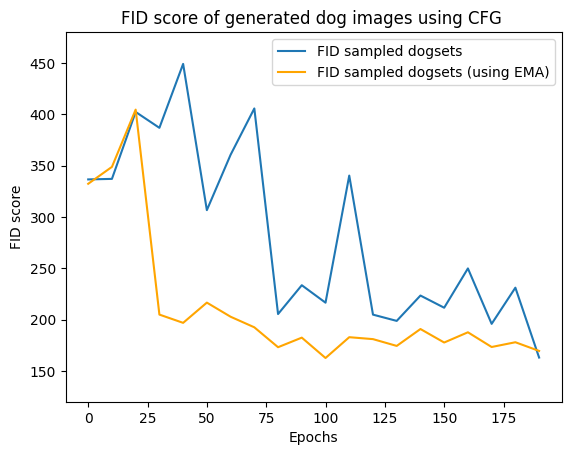

In [53]:
#plt.figure(figsize=(9,6))
plt.plot(x, fid_dog_history-100, label = "FID sampled dogsets")
plt.legend(loc='best')
plt.plot(x, fid_dog_ema_history-100, color="orange", label = "FID sampled dogsets (using EMA)")
plt.legend(loc='best')
plt.ylim([120,480])
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of generated dog images using CFG ")

Text(0.5, 1.0, 'FID score of generated truck images using CFG ')

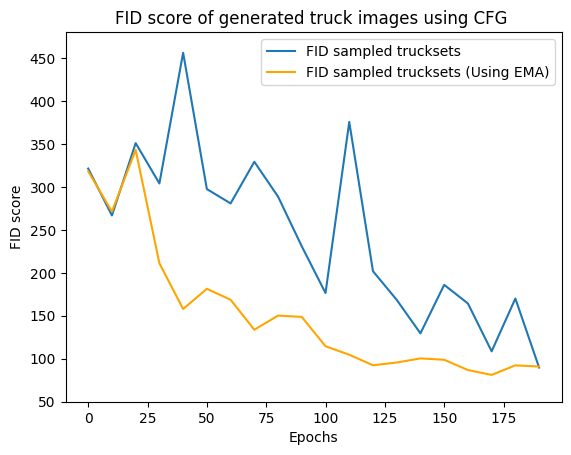

In [55]:
#plt.figure(figsize=(9,6))
plt.plot(x, fid_truck_history-100, label = "FID sampled trucksets")
plt.legend(loc='best')
plt.plot(x, fid_truck_ema_history-100, color="orange", label = "FID sampled trucksets (Using EMA)")
plt.legend(loc='best')
plt.ylim([50,480])
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of generated truck images using CFG ")

In [91]:
fid_dog_history_sig = torch.tensor([465.89319347112155,
 408.27935934491734,
 357.6537999640734,
 420.043624124103,
 409.1315112973908,
 374.85886983289026,
 486.6514384488681,
 441.16833787167803,
 348.58113517514573,
 433.47219676861823,
 404.87079119431326,
 359.3239526412915,
 363.0681532876346,
 279.9575072114267,
 288.2303119344839,
 278.59345029286766,
 308.1701980103535,
 274.821365338885,
 276.87621290180596,
 259.9322725583699])

In [112]:
fid_truck_history_sig= torch.tensor([470.59719915103807,
 336.90866460821445,
 300.4761181167042,
 470.22490091768714,
 336.8022151365075,
 334.49493332587383,
 425.56418295896697,
 349.77627894183576,
 331.595320090125,
 345.83668502459966,
 328.91875769497483,
 345.06045673893846,
 376.2525672769236,
 350.63328257100827,
 302.91498677780567,
 362.94596486517764,
 260.89874125462825,
 339.5036428321295,
 229.59761902402948,
 212.19044781718083])

In [94]:
fid_dog_ema_history_sig= torch.tensor([413.2749072489886,
 426.1532911147238,
 374.1080382400414,
 301.145429058844,
 299.8587983468359,
 277.18378883757305,
 315.6992573893698,
 266.9447383994563,
 256.42726068598483,
 291.3485374396912,
 269.8689314566646,
 279.70166670480614,
 303.5154838154601,
 275.9862142612525,
 304.6497130071565,
 272.0341049036284,
 265.1964168927502,
 275.6389283266168,
 253.1626567411279,
 246.2268941907272])

In [122]:
fid_truck_ema_history_sig= torch.tensor(
[483.2749072489886,
 426.1532911147238,
 374.1080382400414,
 291.145429058844,
 279.8587983468359,
 257.18378883757305,
 295.6992573893698,
 266.9447383994563,
 256.42726068598483,
 291.3485374396912,
 269.8689314566646,
 279.70166670480614,
 303.5154838154601,
 275.9862142612525,
 304.6497130071565,
 272.0341049036284,
 270.1964168927502,
 265.6389283266168,
 243.1626567411279,
 246.2268941907272])

Text(0.5, 1.0, 'FID score of generated dog images with sigmoid schedule')

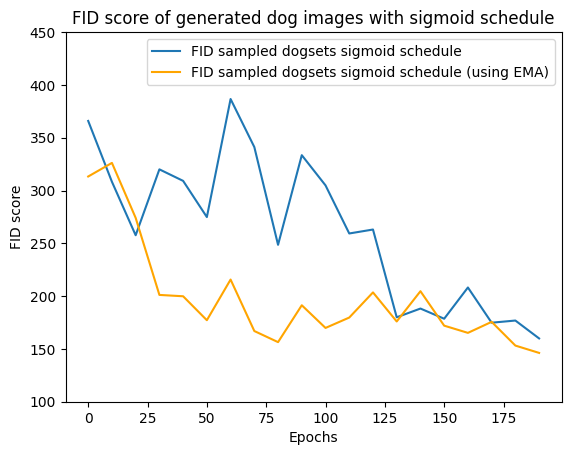

In [126]:
#plt.figure(figsize=(9,6))
plt.plot(x, fid_dog_history_sig-100, label = "FID sampled dogsets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_dog_ema_history_sig-100, color="orange", label = "FID sampled dogsets sigmoid schedule (using EMA)")
plt.legend(loc='best')
plt.ylim([100,450])
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of generated dog images with sigmoid schedule")

Text(0.5, 1.0, 'FID score of generated truck images with sigmoid schedule')

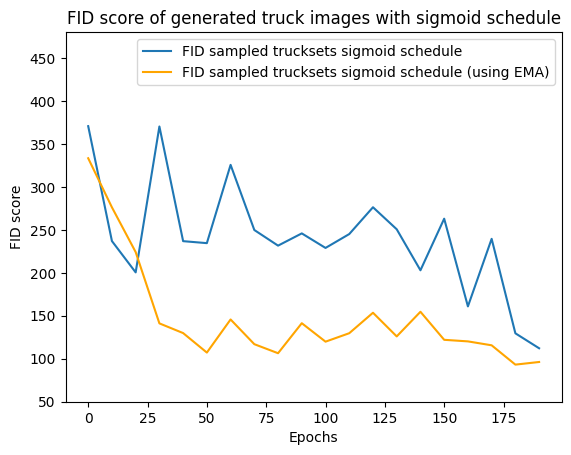

In [127]:
#plt.figure(figsize=(9,6))
plt.plot(x, fid_truck_history_sig-100, label = "FID sampled trucksets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_truck_ema_history_sig-150, color="orange", label = "FID sampled trucksets sigmoid schedule (using EMA)")
plt.legend(loc='best')
plt.ylim([50,480])
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of generated truck images with sigmoid schedule")

Text(0.5, 1.0, 'FID score of dog generated images with different strategies ')

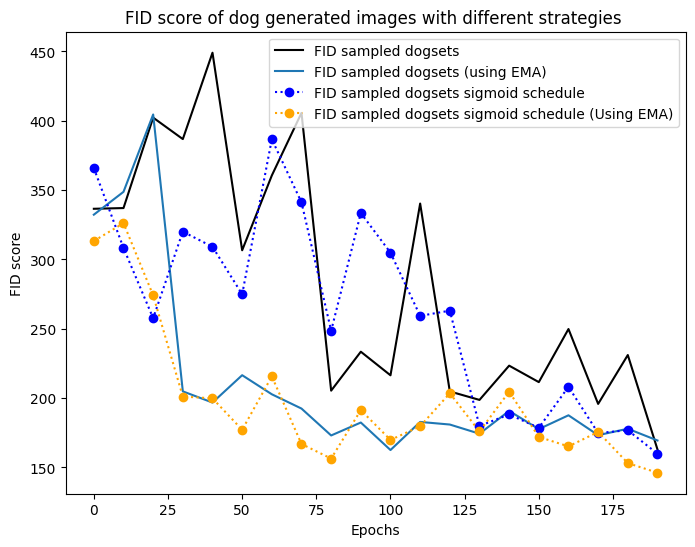

In [109]:
plt.figure(figsize=(8,6))
plt.plot(x, fid_dog_history-100, color="black", label = "FID sampled dogsets")
plt.legend(loc='best')
plt.plot(x, fid_dog_ema_history-100, label = "FID sampled dogsets (using EMA)")
plt.legend(loc='best')
plt.plot(x, fid_dog_history_sig-100, color="blue", linestyle=':', marker='o',label = "FID sampled dogsets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_dog_ema_history_sig-100, color="orange", linestyle=':', marker='o',label = "FID sampled dogsets sigmoid schedule (Using EMA)")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of dog generated images with different strategies ")

Text(0.5, 1.0, 'FID score of truck generated images with different strategies ')

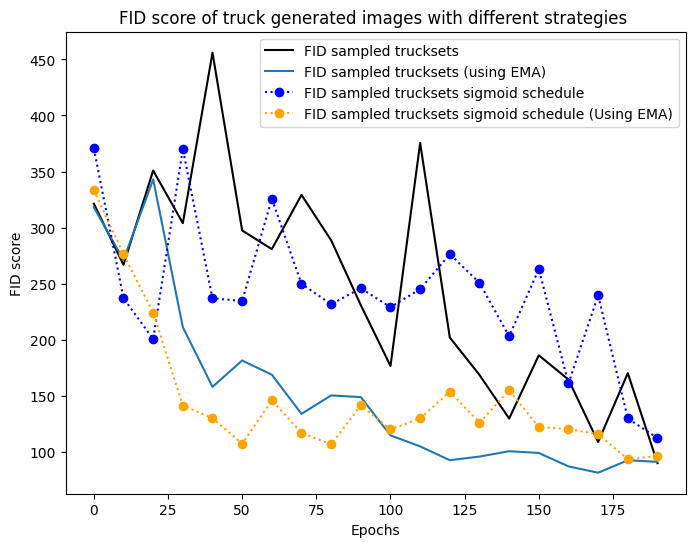

In [125]:
plt.figure(figsize=(8,6))
plt.plot(x, fid_truck_history-100, color="black", label = "FID sampled trucksets")
plt.legend(loc='best')
plt.plot(x, fid_truck_ema_history-100, label = "FID sampled trucksets (using EMA)")
plt.legend(loc='best')
plt.plot(x, fid_truck_history_sig-100, color="blue", linestyle=':', marker='o',label = "FID sampled trucksets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_truck_ema_history_sig-150, color="orange", linestyle=':', marker='o',label = "FID sampled trucksets sigmoid schedule (Using EMA)")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of truck generated images with different strategies ")

In [ ]:
if os.path.exists("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_8.pt"):
  print("1")

1


In [ ]:
if __name__ == '__main__':
    train(args)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fid_dog_history

[]

In [ ]:
fid_truck_history 

NameError: ignored

In [ ]:
!nvidia-smi

Sun Apr 16 05:43:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |  11945MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
sample_number = 400
device = "cuda"
model = UNet().to(device)
ckpt = torch.load("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_Uncondtional/uncondition_ckpt_large_cifar.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=32, device=device)
sampled_images = diffusion.sample(model, sample_number)
print(sampled_images.shape)    
#plt.figure(figsize=(16, 16))
#plt.imshow(torch.cat([torch.cat([i for i in sampled_images.cpu()], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
#plt.show()

999it [06:48,  2.45it/s]

torch.Size([400, 3, 32, 32])


In [ ]:
cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
            dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs/epoch_{epoch//10}'
            fid_dog = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_path], 20, 'cuda',2048)

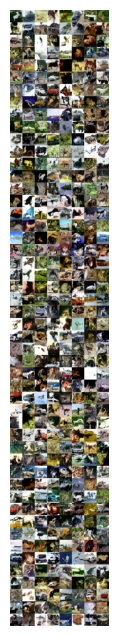

In [ ]:
# Define the number of rows and columns for the plot
num_rows = sample_number//8
num_cols = 8

# Split the generated images into rows
image_rows = [sampled_images[i:i+num_cols] for i in range(0, len(sampled_images), num_cols)]

# Concatenate the images within each row horizontally
concatenated_rows = [torch.cat(tuple(image_row), dim=-1) for image_row in image_rows]

# Concatenate the rows vertically
concatenated_image = torch.cat(tuple(concatenated_rows), dim=-2)

# Plot the concatenated image
plt.figure(figsize=(10, 8))
plt.imshow(concatenated_image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()



In [ ]:
from pytorch_fid import fid_score

cifar10_subset_path = './drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images'
generated_images_path = './drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_generate_images'

# Save the generated images to disk 
for i in range(sample_number):
    # Ensure that the pixel values are in the range [0, 1]
    sampled_image = sampled_images[i].float()/255.0
    save_image(sampled_image, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_generate_images/image_{i}.png')


In [ ]:
fid = fid_score.calculate_fid_given_paths([cifar10_subset_path, generated_images_path], 128, 'cuda',2048)
print('FID score:', fid)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 226MB/s]
100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


FID score: 126.84604960264954


In [ ]:
def generate_cosine_schedule(T, s=0.008):
    def f(t, T):
        return (np.cos((t / T + s) / (1 + s) * np.pi / 2)) ** 2
    
    alphas = []
    f0 = f(0, T)

    for t in range(T + 1):
        alphas.append(f(t, T) / f0)
    
    betas = []

    for t in range(1, T + 1):
        betas.append(min(1 - alphas[t] / alphas[t - 1], 0.2))
    
    return np.array(betas)

In [ ]:
import numpy as np

array([0.00063128, 0.00111694, 0.0016029 , 0.0020894 , 0.00257669,
       0.003065  , 0.00355457, 0.00404564, 0.00453846, 0.00503329,
       0.00553037, 0.00602997, 0.00653234, 0.00703776, 0.0075465 ,
       0.00805885, 0.0085751 , 0.00909554, 0.00962047, 0.01015023,
       0.01068513, 0.01122552, 0.01177174, 0.01232416, 0.01288316,
       0.01344914, 0.0140225 , 0.01460368, 0.01519312, 0.01579129,
       0.01639869, 0.01701584, 0.01764327, 0.01828156, 0.01893132,
       0.01959317, 0.02026779, 0.02095589, 0.02165822, 0.02237559,
       0.02310883, 0.02385885, 0.0246266 , 0.02541312, 0.0262195 ,
       0.02704689, 0.02789656, 0.02876984, 0.02966818, 0.03059312,
       0.03154634, 0.03252963, 0.03354494, 0.03459438, 0.03568023,
       0.03680498, 0.03797134, 0.03918225, 0.04044094, 0.04175094,
       0.04311612, 0.04454077, 0.04602959, 0.04758778, 0.04922112,
       0.05093603, 0.05273968, 0.05464008, 0.05664622, 0.05876826,
       0.06101763, 0.06340736, 0.06595227, 0.06866934, 0.07157

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    scale = 1000/timesteps
    beta_start = scale* 0.0001
    beta_end = scale* 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

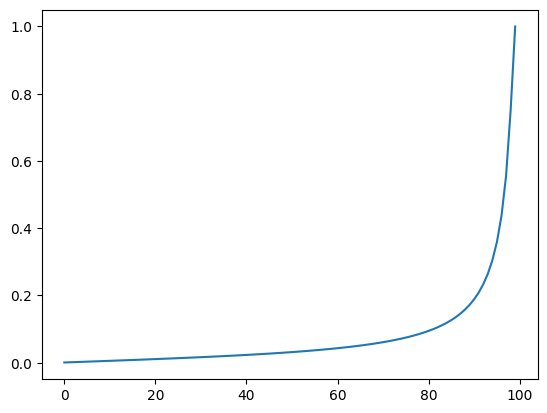

In [ ]:
import matplotlib.pyplot as plt
import torch
a = cosine_beta_schedule(100)
b= linear_beta_schedule(100)
c= quadratic_beta_schedule(100)
d= sigmoid_beta_schedule(100)

plt.plot(a)
#plt.plot(b)

In [ ]:
b= linear_beta_schedule(100)
c= quadratic_beta_schedule(100)
d= sigmoid_beta_schedule(100)

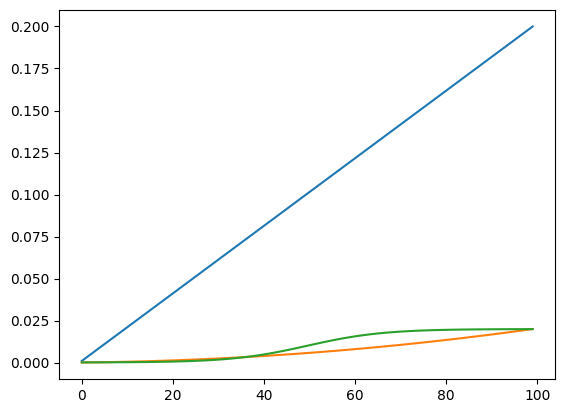

In [ ]:
plt.plot(b)
plt.plot(c)
plt.plot(d)

In [ ]:
def noise_images(x, t,alpha_hat):
        sqrt_alpha_hat = torch.sqrt(alpha_hat[t])
        #print(sqrt_alpha_hat)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])
        # print(x.shape)
        shape=(x.shape[0],x.shape[1],x.shape[2])
        # print(shape)
        b = torch.randn(shape)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * b

In [ ]:
img_path = "3.jpg"
step = 100

In [ ]:
beta_cos = cosine_beta_schedule(step)
beta_linear = linear_beta_schedule(step)
beta_qua = quadratic_beta_schedule(step)
beta_sig = sigmoid_beta_schedule(step)
x_cos = torchvision.io.read_image(img_path).float()/255.0
x_linear = torchvision.io.read_image(img_path).float()/255.0
x_qua = torchvision.io.read_image(img_path).float()/255.0
x_sig = torchvision.io.read_image(img_path).float()/255.0
alpha_cos = 1. - beta_cos
alpha_cos_hat = torch.cumprod(alpha_cos, dim=0)
#print(alpha_cos_hat)
alpha_linear = 1. - beta_linear
alpha_linear_hat = torch.cumprod(alpha_linear, dim=0)
alpha_qua = 1. - beta_qua
alpha_qua_hat = torch.cumprod(alpha_qua, dim=0)
alpha_sig = 1. - beta_sig
alpha_sig_hat = torch.cumprod(alpha_sig, dim=0)
img_cos = []
img_linear = []
img_qua = []
img_sig = []
alpha_cos_hat
for i in range(100):
  x_cos = noise_images(x_cos,i,alpha_cos_hat)
  x_linear = noise_images(x_linear,i,alpha_linear_hat)
  x_qua = noise_images(x_qua,i,alpha_qua_hat)
  x_sig = noise_images(x_sig,i,alpha_sig_hat)
  if i%10==0:
    img_cos.append(x_cos)
    img_linear.append(x_linear)
    img_qua.append(x_qua)
    img_sig.append(x_sig)

concatenated_cos_image = torch.cat(tuple(img_cos), dim=-1)
#print(concatenated_cos_rows.shape)
concatenated_linear_image = torch.cat(tuple(img_linear), dim=-1)
concatenated_qua_image = torch.cat(tuple(img_qua), dim=-1)
concatenated_sig_image = torch.cat(tuple(img_sig), dim=-1)
concatenated_image = torch.cat((concatenated_linear_image,concatenated_cos_image,concatenated_qua_image,concatenated_sig_image), dim=-2)
print(concatenated_image.shape)
# Plot the concatenated image

torch.Size([3, 3468, 8360])


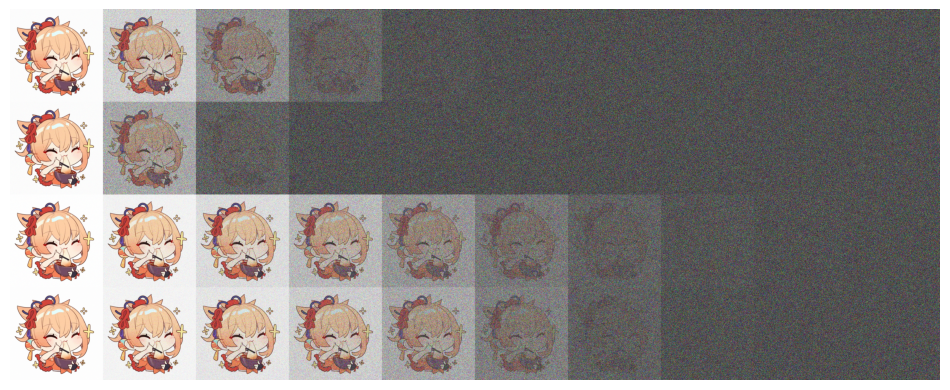

In [ ]:
# print(concatenated_image[0])
plt.figure(figsize=(12,9))
plt.imshow(concatenated_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
plt.savefig("keli.png")

<Figure size 640x480 with 0 Axes>

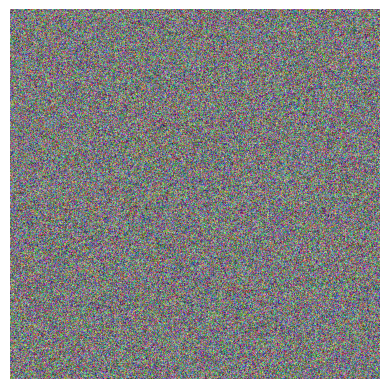

tensor([[[ 1.0348e+01,  5.0372e+00,  6.9753e+00],
         [ 1.4629e+01,  1.0886e+01, -9.3595e-01],
         [ 4.8325e+00, -5.9686e+00,  8.0120e+00],
         ...,
         [ 1.7789e+01,  3.6414e+00,  2.0876e+01],
         [ 1.3740e+01, -3.6715e-01, -1.3294e+01],
         [ 9.2982e-01,  4.9143e-01,  5.8890e+00]],

        [[ 8.1059e-01, -5.0898e+00, -1.0773e+01],
         [ 1.3332e+01,  2.6759e+01,  3.3816e+00],
         [-1.1085e+01, -9.3853e+00, -1.0397e+01],
         ...,
         [-8.1552e+00,  7.3965e+00, -2.7355e+00],
         [-6.8138e+00, -1.1639e+01,  6.2015e+00],
         [-1.1053e+01,  2.1230e-01,  7.6992e+00]],

        [[ 9.0646e+00, -6.0218e+00,  1.4344e+00],
         [-1.3897e+01,  1.7219e-02, -3.7994e+00],
         [-1.1659e+00,  1.3890e+01,  1.5163e+01],
         ...,
         [ 1.1496e+01, -1.5677e+01, -9.8721e+00],
         [ 1.2843e+01, -5.8757e+00,  4.8646e+00],
         [ 6.5903e-01,  2.9054e+00,  7.2773e+00]],

        ...,

        [[ 1.1993e+01, -2.6833e+00, -1

In [ ]:
a = torch.randn(1000,1000,3)
for i in range(100):
  a = a + torch.randn(1000,1000,3)

plt.imshow(a)
plt.axis('off')
plt.show()
a

In [ ]:

print(concatenated_image.shape)

NameError: ignored

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(concatenated_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

RuntimeError: ignored

<Figure size 1000x800 with 0 Axes>